# Focus on what matters: inferring low-dimensional dynamics from neural recordings

**By Neuromatch Academy**

__Content creators:__ Marius Pachitariu, Pedram Mouseli, Lucas Tavares, Jonny Coutinho, 
Blessing Itoro, Gaurang Mahajan, Rishika Mohanta

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective: 
It is very difficult to interpret the activity of single neurons in the brain, because their firing patterns are noisy, and it is not clear how a single neuron can contribute to cognition and behavior. However, neurons in the brain participate in local, regional and brainwide dynamics. No neuron is isolated from these dynamics, and much of a single neuron's activity can be predicted from the dynamics. Furthermore, only populations of neurons as a whole can control cognition and behavior. Hence it is crucial to identify these dynamical patterns and relate them to stimuli or behaviors. 

In this notebook, we generate simulated data from a low-dimensional dynamical system and then use seq-to-seq methods to predict one subset of neurons from another. This allows us to identify the low-dimensional dynamics that are sufficient to explain the activity of neurons in the simulation. The methods described in this notebook can be applied to large-scale neural recordings of hundreds to tens of thousans of neurons, such as the ones from the NMA-CN course.

---
# Setup

In [1]:
# Imports
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Note:** If `cuda` is not enabled, go to `Runtime`--> `Change runtime type` and in `Hardware acceleration` choose `GPU`. 

---
# Simulate some data from a linear dynamical system

In [4]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

# we simulate 200 neurons
NN = 400 

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0 = .025 * np.random.randn(ncomp, NN)

# We generate the dynamics of the low-d system. We initialize the latent state. 

# start by initializing the latents
y       = 2 * np.random.randn(ncomp)
latents = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep
for t in range(NT):
  y = y @ A0 +  np.random.randn(ntrials, ncomp) 
  latents[t] = y

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0)

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
x = np.random.poisson(rates)

---
#  Define RNN

In [5]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN! 
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')        
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)
    
    return z, q

---
# Plot and Prepare data

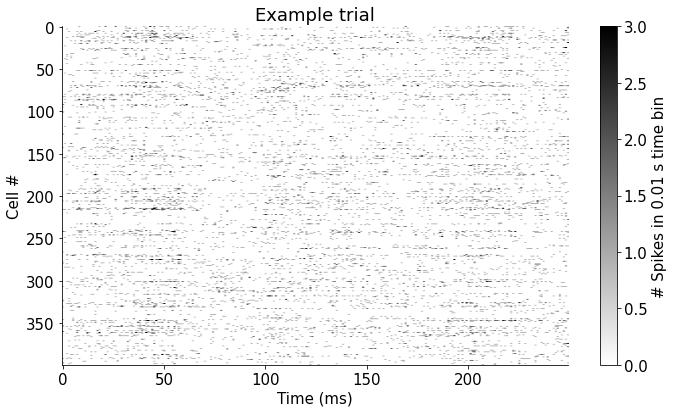

In [6]:
plt.figure(figsize = (10, 6))
plt.imshow(x[:, 0, :].T, cmap='gray_r', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
plt.title('Example trial')
plt.show()

In [7]:
# we separate the neuron data into two populations: the input and output
x0 = torch.from_numpy(x[:, :, :200]).to(device).float()
x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()

NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons. 
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes. 
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

---
# Train the RNN

In [8]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

niter = 1000
for k in range(niter): 
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1)    

    # our log-likelihood cost
    cost = Poisson_loss(z, x0).mean()

    # train the network as usual
    cost.backward()    
    optimizer.step()
    optimizer.zero_grad()

    if k % 100 == 0:
        print(f'iteration {k}, cost {cost.item():.4f}')

iteration 0, cost 0.4126
iteration 100, cost 0.2568
iteration 200, cost 0.2431
iteration 300, cost 0.2388
iteration 400, cost 0.2385
iteration 500, cost 0.2372
iteration 600, cost 0.2368
iteration 700, cost 0.2367
iteration 800, cost 0.2366
iteration 900, cost 0.2365


---
# Compare true firing rates with the predicted.

Note that for real data we only get the spikes, not the true firing rates! 

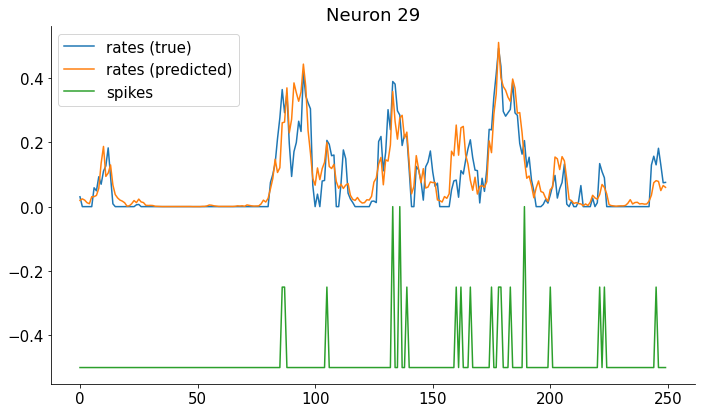

In [9]:
rpred = z.detach().cpu().numpy()

nn = 29
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nn, 0])
plt.plot(rpred[:,nn, 0])
plt.plot(-.5 + x[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()

## View firing rates for all neurons in one trial

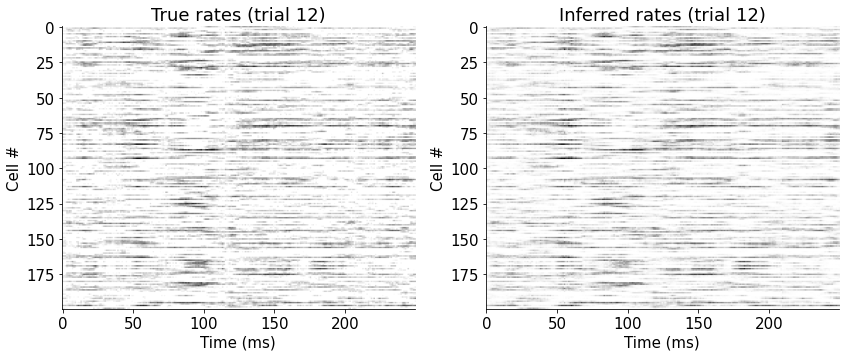

In [10]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, 12, :200].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('True rates (trial 12)')

plt.subplot(122)
plt.imshow(rpred[:, 12, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title('Inferred rates (trial 12)')
plt.show()

---
# Visualize the latent dynamics

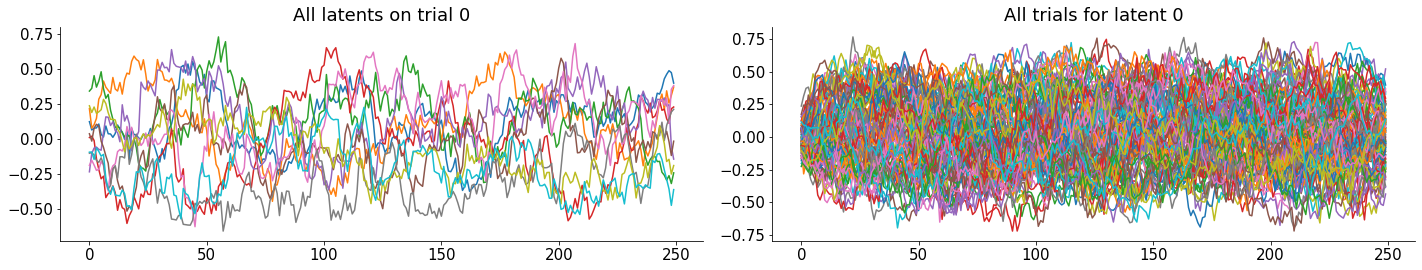

In [11]:
ycpu = y.detach().cpu().numpy()

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.plot(ycpu[:, 0, :]);
plt.title('All latents on trial 0')

plt.subplot(122)
plt.plot(ycpu[:, :, 0]);
plt.title('All trials for latent 0')
plt.show()

Not much to see for the latents. This is not surprising, since we generated them with random data, so they look just like a random walk process. 

Now apply this model on real data and see if you can interpret the latents. 

